In [1]:
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as fn
from sklearn.utils import shuffle
import torch.optim as optim
import torch
import torch.utils.data as data
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
m = 10000

## dataset -> list of tuples, first is human and second machine
## human vocab -> letters/numbers to index
## machine_vocab -> numbers and dash to index
## inv machine vocab -> index to numbers and dash

dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 21725.81it/s]


In [3]:
max_human_length = 30
max_machine_length = 10
## truncates if smaller than length and pads if shorter. also fills in with unk
## x is np array for each training example as a list of indexes. Same for y
X, Y = preprocess_data(dataset, human_vocab, machine_vocab, max_human_length, max_machine_length)

In [4]:
class DateDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = len(X)
        
    def __getitem__(self, index):
        human = torch.LongTensor(self.X[index]).to(device)
        machine = torch.LongTensor(self.Y[index]).to(device)
        return human, machine
        
    def __len__(self):
        return self.len

date_dataset = DateDataset(X, Y)

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, human_vocab_size):
        super(Encoder, self).__init__()
        
        self.human_embedding = nn.Embedding(human_vocab_size, 50)
        self.pre_attention_bilstm = nn.LSTM(50, 32, bidirectional=True, 
                                           batch_first=True)
        
    def forward(self, human_indexes):
        human_embeds = self.human_embedding(human_indexes)
        pre_lstm, _ = self.pre_attention_bilstm(human_embeds)
        return pre_lstm
    
class Decoder(nn.Module):
    
    """
    Doesn't actually take in previous character as likely not very correlated.
    Most of the correlation lies within the encoder vectors
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.hidden_size = 64
        ## 128 b/c concat 2*64
        self.densor1 = nn.Linear(128, 10)
        self.densor2 = nn.Linear(10, 1)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.dense_out = nn.Linear(64, 11)
        self.embedding = nn.Embedding(11, 64)
        
    def forward(self, previous_hidden, previous_cell, encodings):
        batch_size = encodings.shape[0]
        previous_hidden_expanded = previous_hidden.view(batch_size, 1, -1)
        previous_hidden_expanded = previous_hidden_expanded.repeat(1, 30, 1)
        concat_vector = torch.cat((previous_hidden_expanded, encodings), 2)
        densor1_out =  fn.tanh(self.densor1(concat_vector))
        densor2_out = fn.relu(self.densor2(densor1_out))
        self.attention_weights = fn.softmax(densor2_out, 1)
        attention_weights_view = self.attention_weights.view(batch_size, 1, 30)
        weighted_encodings = torch.bmm(attention_weights_view, encodings)
        lstm_out, (h_out, c_out) = self.lstm(weighted_encodings, 
                                             (previous_hidden, previous_cell))
        out = self.dense_out(lstm_out).squeeze(1)
        return out, h_out, c_out
        
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    
    def getAttentionWeights(self):
        return self.attention_weights

In [6]:
n_epochs = 4
learning_rate = 0.001
batch_size = 16

encoder = Encoder(len(human_vocab)).to(device)
decoder = Decoder().to(device)
data_loader = data.DataLoader(dataset=date_dataset,
                             batch_size=batch_size,
                             shuffle=True)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [7]:
total_loss = 0
total_i = 0
losses = []
print_n = 200
for epoch in range(n_epochs):
    for i, (x, machine_date_indexes) in enumerate(data_loader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        pre_lstm_vectors = encoder(x)
        
        previous_hidden = decoder.initHidden(batch_size)
        previous_cell = decoder.initHidden(batch_size)
        
        loss = 0
        for j in range(10):
            out, previous_hidden, previous_cell = decoder(previous_hidden, previous_cell, pre_lstm_vectors)
            actuals = machine_date_indexes[:,j]
            loss += criterion(out, actuals)
            
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        
        total_i += 1
        total_loss += loss.item()
        if (epoch * len(data_loader) + i) % print_n == 0:
            print("{0}/{1}".format(epoch * len(data_loader) + i, 
                                   n_epochs*len(data_loader)))
            avg_loss = total_loss / total_i
            total_i = 0
            total_loss = 0
            print("Avg Loss: {}".format(avg_loss))
            losses.append(avg_loss)

0/2500
Avg Loss: 24.087318420410156
200/2500
Avg Loss: 18.363502821922303
400/2500
Avg Loss: 10.043102557659148
600/2500
Avg Loss: 7.36011468410492
800/2500
Avg Loss: 4.358691869974137
1000/2500
Avg Loss: 1.640362522006035
1200/2500
Avg Loss: 0.5821093444526195
1400/2500
Avg Loss: 0.2575613734126091
1600/2500
Avg Loss: 0.1422294796258211
1800/2500
Avg Loss: 0.08900793068110943
2000/2500
Avg Loss: 0.05946274444460869
2200/2500
Avg Loss: 0.0432068358361721
2400/2500
Avg Loss: 0.03361487060785293


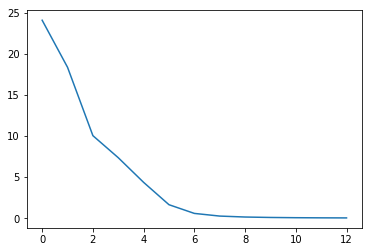

In [8]:
plt.plot(losses)

In [9]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 
            'Tue 10 Jul 2007', 'Saturday May 9 2018', 
            'March 3 2001', 'March 3rd 2001', '1 March 2001']
encoder.eval()
decoder.eval()
all_weights = []
outputs = []
with torch.no_grad():
    for example in EXAMPLES:

        source = string_to_int(example, max_human_length, human_vocab)

        x = torch.LongTensor(source).unsqueeze(0).to(device)
        
        
        pre_lstm_vectors = encoder(x)
        
        previous_hidden = decoder.initHidden(1)
        previous_cell = decoder.initHidden(1)
        
        prediction = []
        attn_weights = []
        
        for _ in range(max_machine_length):
            out, previous_hidden, previous_cell = decoder(previous_hidden, previous_cell, pre_lstm_vectors)
            out = out.squeeze(0)
            attn_weights.append(decoder.getAttentionWeights().data.cpu().numpy()[0,:,0])
            out_max = out.argmax()
            prediction.append(out_max.item())

        output = [inv_machine_vocab[int(i)] for i in prediction]
        
        outputs.append(output)
        all_weights.append(attn_weights)

        print("source:", example)
        print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-01
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


## Visualize Weights

In [10]:
def plot_attn(attn_weights, input_sent, output_sent):
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attn_weights, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(10))
    ax.set_yticklabels(output_sent)

    ax.set_xticks(range(30))
    ax.set_xticklabels(input_sent[:30], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

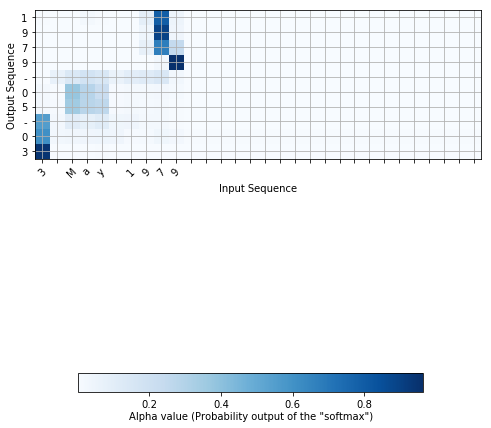

In [11]:
index=0
plot_attn(all_weights[index], EXAMPLES[index], outputs[index])